In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys

In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.01]
teff = [4750, 100]
bp_rp = [1.34, 0.01]

In [3]:
# Initialize a jam session with a single star:
#jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], bp_rp = [bp_rp])
#jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], bp_rp = [bp_rp], kwargs = {'quarter': [5]})

# with more than one star:
jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], bp_rp = [bp_rp,bp_rp], teff = [teff,teff])


# # with own timeseries:
# time,flux = np.genfromtxt('Examples/mypsd.asciifile').T
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], 
#                    teff = [teff], bp_rp = [bp_rp], timeseries = [(time,flux)])

# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = [(time,flux),(time,flux)])

# # in ascii format
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], timeseries = ['Examples/myts.asciifile'])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = ['Examples/myts.asciifile','Examples/myts.asciifile'])

# # in lightkurve format
# lc = lk.search_lightcurvefile(target=kic, quarter=5, cadence = 'long').download().PDCSAP_FLUX
# lc = lc.remove_nans().remove_outliers().flatten().normalize()
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], timeseries = [lc])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = [lc,lc])


# # with own powerspectrum:
# freq, power = np.genfromtxt('Examples/mypsd.asciifile').T
# jam_sess = session(ID = [kic], numax = [numax],dnu = [dnu], teff = [teff], psd = [(freq, power)])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = [(freq, power),(freq, power)])

# # in ascii format:
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], psd = ['Examples/mypsd.asciifile'])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = ['Examples/mypsd.asciifile','Examples/mypsd.asciifile'])

# # in lightkurve format
# time, flux = np.array(lc.time), np.array(lc.flux)
# pg = lk.LightCurve(time, flux).to_periodogram(normalization='psd').flatten()
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], psd = [pg])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = [pg,pg])

{'cadence': [None, None], 'month': [None, None], 'quarter': [None, None], 'campaign': [None, None], 'sector': [None, None]}


In [4]:
# Result is always a list of star class instances
# Taking the first one as an example
star = jam_sess.stars[0]

In [5]:
# Do mode ID for one of the stars using the asymptotic method on 7 radial orders
star.asymptotic_modeid(norders = 7)

Burningham
Sampling


In [6]:
# Result is a dataframe
print(star.asy_modeID)

    ell       nu_mu    nu_std
0     2  157.465600  0.071548
1     0  159.660055  0.066922
2     2  174.085878  0.041260
3     0  176.280952  0.035706
4     2  190.820979  0.024986
5     0  193.015060  0.018780
6     2  207.669323  0.021639
7     0  209.863649  0.017183
8     2  224.630943  0.021521
9     0  226.825526  0.018210
10    2  241.706492  0.021991
11    0  243.899746  0.018337
12    2  258.895699  0.032396
13    0  261.089794  0.028795


(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc985519d68>)

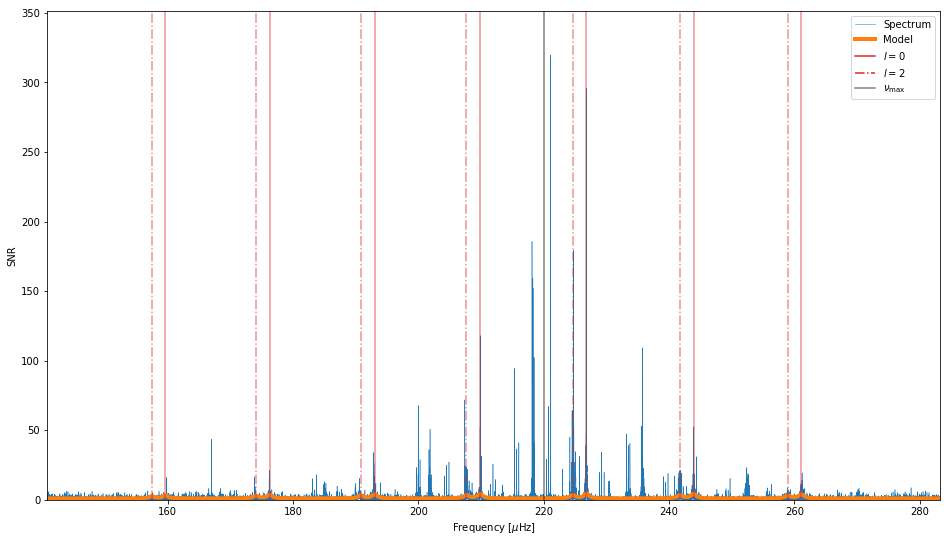

In [7]:
star.plot_asyfit()

In [8]:
# tgt = lk.search_lightcurvefile(target=kic, quarter=[5],)

In [9]:
# tgt

In [10]:
# lc_col = tgt.download_all()
# print(lc_col)

In [11]:
# for i,lc in enumerate(lc_col[1:]):
#     print(i)

In [12]:
# LC = np.array([]).reshape((0,2))
# for i,lc in enumerate(lc_col):
#     lc = lc.PDCSAP_FLUX.remove_nans().normalize().flatten().remove_outliers()
#     c = np.array([lc.time,(lc.flux-1)*1e6]).T
#     LC = np.concatenate((LC,c), axis = 0)

In [13]:
# lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
# print(type(lc))
# for q in range(2,8):
#     lc0=lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
#     lc = lc.append(lc0)

In [14]:
# def clean_lc(lc):
#     lc = lc.remove_nans().normalize().flatten().remove_outliers()
#     lc.flux = (lc.flux-1)*1e6
#     return lc 

# tgt = lk.search_lightcurvefile(target=kic)
# lc_col = tgt.download_all()
# lc0 = clean_lc(lc_col[0].PDCSAP_FLUX)
# for i,lc in enumerate(lc_col[1:]):
#     lc0 = lc0.append(clean_lc(lc.PDCSAP_FLUX))


In [15]:
# from matplotlib.pyplot import *
# figure()
# plot(lc0.time,lc0.flux,'.')

In [16]:
# lc.append(lc)